# Lecture 9 Deep Learning

In [2]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
# Load dataset
raw = pd.read_csv(os.path.join('data', 'l9', 'aiif_eikon_id_eur_usd.csv'), index_col=0, parse_dates=True)
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


## Dense Neural Network
This example uses EUR/USD intraday price data obtained from the Refinitiv Eikon Data API.
The dataset contains open, high, low, and close values for the EUR/USD currency pair, sampled at regular time intervals.
It is used to illustrate deep learning models for financial time-series prediction.

Foreign exchange (FX) data, such as EUR/USD, is particularly suitable for this task because it is liquid, continuously traded, and publicly available at high frequency.
By modeling such data, we can explore how neural networks capture temporal dependencies and potential statistical inefficiencies in asset prices.

In [5]:
symbol = 'EUR_USD'
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]
data = data.resample('1h', label='right').last().ffill()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 01:00:00 to 2020-01-01 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


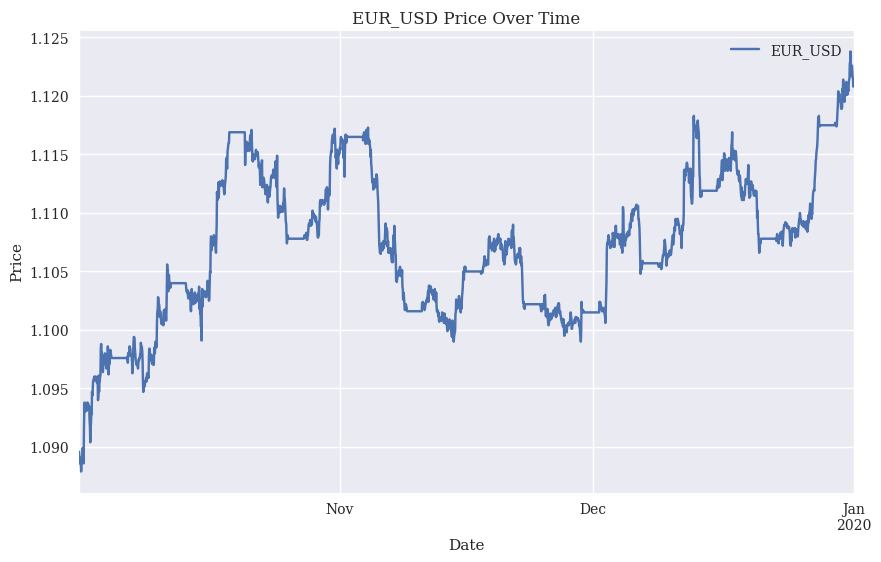

In [6]:
data.plot(figsize=(10, 6))
plt.title(f'{symbol} Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Baseline Prediction

In [7]:
lags = 5

def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

data, cols = add_lags(data, symbol, lags)
len(data)

2183

In [8]:
c = data['d'].value_counts()
print(c)

d
0    1445
1     738
Name: count, dtype: int64


In [9]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = float(len(df) / (2 * c0))
    w1 = float(len(df) / (2 * c1))
    return {0: w0, 1: w1}

In [10]:
class_weight = cw(data)
print(class_weight)

{0: 0.755363321799308, 1: 1.4789972899728998}


In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [12]:
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2

In [13]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [14]:
def create_model(hl=1, hu=128, lr=0.001, dropout=None, regularize=False, reg=l1(0.0005), 
                 input_dim=len(cols), optimizer=None):
    """Build a feedforward binary classification model.
    hl: number of additional hidden layers (after first)
    hu: units per hidden layer
    lr: learning rate
    dropout: optional dropout rate (e.g., 0.2)
    """
    keras.backend.clear_session()
    inputs = keras.Input(shape=(input_dim,), name="features")
    if regularize:
        x = Dense(hu, activation='relu', kernel_regularizer=reg)(inputs)
    else:
        x = Dense(hu, activation='relu')(inputs)
    if dropout:
        from keras.layers import Dropout
        x = Dropout(dropout)(x)
    for _ in range(hl):
        x = Dense(hu, activation='relu')(x)
        if dropout:
            x = Dropout(dropout)(x)
    outputs = Dense(1, activation='sigmoid', name="prob")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    if not optimizer:
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

In [15]:
set_seeds()
model = create_model(hl=1, hu=128)

In [16]:
%%time
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=cw(data))

CPU times: total: 7.05 s
Wall time: 5.17 s


In [17]:
model.evaluate(data[cols], data['d'])

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5928 - loss: 0.5950  


[0.5949821472167969, 0.5927622318267822]

In [18]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)
data['p'].value_counts()

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


p
1    1469
0     714
Name: count, dtype: int64

In [19]:
split = int(len(data) * 0.8)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()
set_seeds()
model = create_model(hl=1, hu=128)


In [20]:
%%time 
hist = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: total: 7.91 s
Wall time: 6.18 s


In [21]:
model.evaluate(train[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.5830 - loss: 0.6278


[0.6278444528579712, 0.5830469727516174]

In [22]:
model.evaluate(test[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6087 - loss: 0.6113 


[0.6113342642784119, 0.6086956262588501]

In [23]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)
test['p'].value_counts()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


p
1    294
0    143
Name: count, dtype: int64

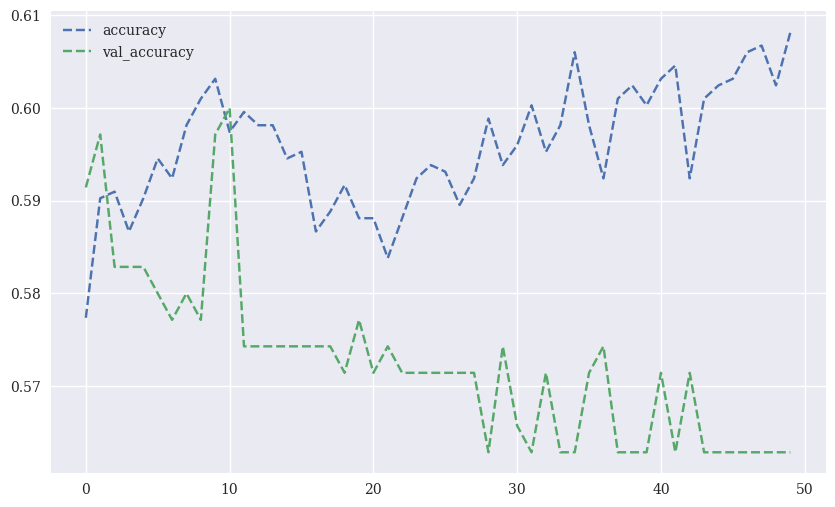

In [24]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

### Normalization

In [25]:
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

In [26]:
set_seeds()
model = create_model(hl=2, hu=128)

In [27]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: total: 8.86 s
Wall time: 6.35 s


In [28]:
model.evaluate(train_[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8883 - loss: 0.4403 


[0.4403088092803955, 0.8883161544799805]

In [29]:
test_ = (test - mu) / std

In [30]:
model.evaluate(test_[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6728 - loss: 1.4878 


[1.4878273010253906, 0.6727688908576965]

In [31]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)
test['p'].value_counts()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


p
0    385
1     52
Name: count, dtype: int64

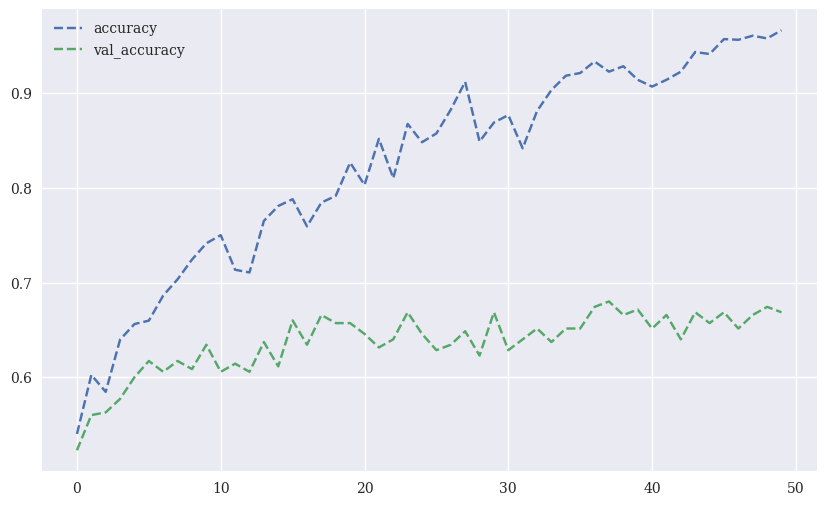

In [32]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

### Dropout

In [33]:
set_seeds()
model = create_model(hl=1, hu=128, dropout=0.3)

In [34]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=cw(train))

CPU times: total: 9 s
Wall time: 6.44 s


In [35]:
model.evaluate(train_[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7520 - loss: 0.4779 


[0.47793179750442505, 0.7520045638084412]

In [36]:
model.evaluate(test_[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6453 - loss: 0.5705 


[0.57045578956604, 0.6453089118003845]

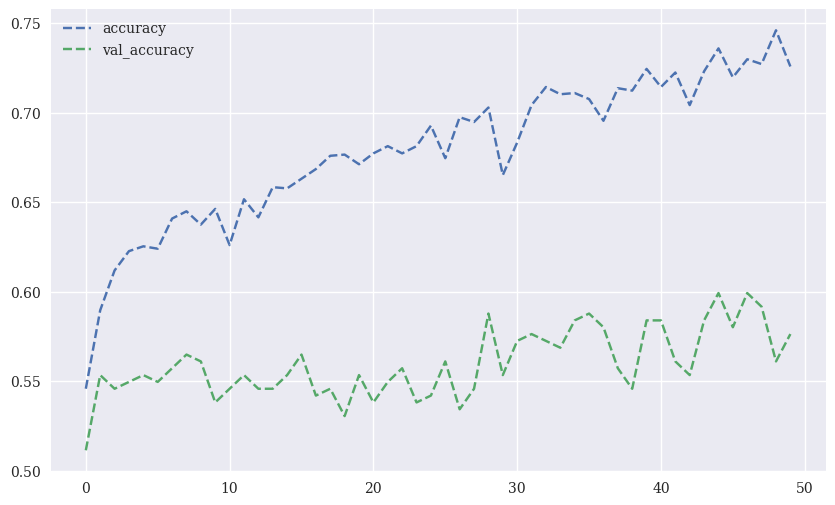

In [37]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

### Regularization

In [38]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [39]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: total: 8.53 s
Wall time: 6.37 s


In [40]:
model.evaluate(train_[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8282 - loss: 0.5175


[0.5174855589866638, 0.8281787037849426]

In [41]:
model.evaluate(test_[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6705 - loss: 0.9163 


[0.9163384437561035, 0.6704805493354797]

<Axes: >

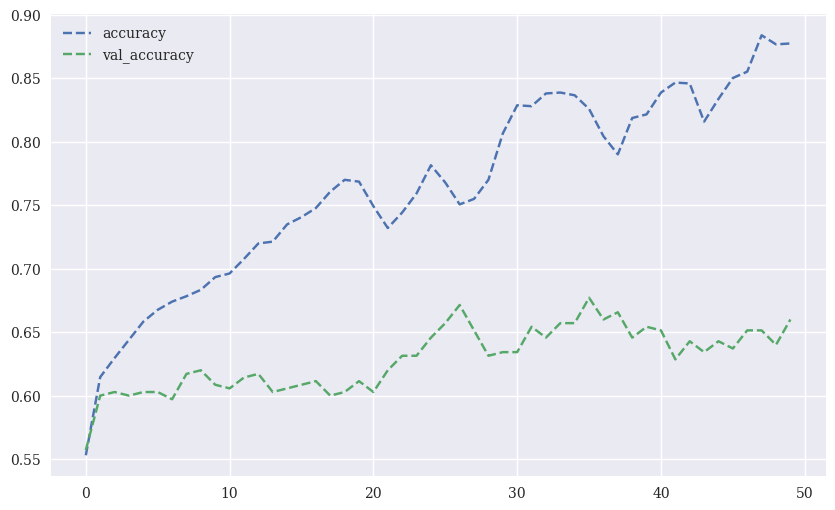

In [42]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

In [43]:
set_seeds()
model = create_model(hl=2, hu=128, dropout=0.3,
                     regularize=True, reg=l2(0.001),
                    )

In [44]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: total: 10.1 s
Wall time: 7.21 s


In [45]:
model.evaluate(train_[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6942 - loss: 0.5502 


[0.5502367615699768, 0.6941580772399902]

In [46]:
model.evaluate(test_[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6590 - loss: 0.5953 


[0.5953022837638855, 0.6590389013290405]

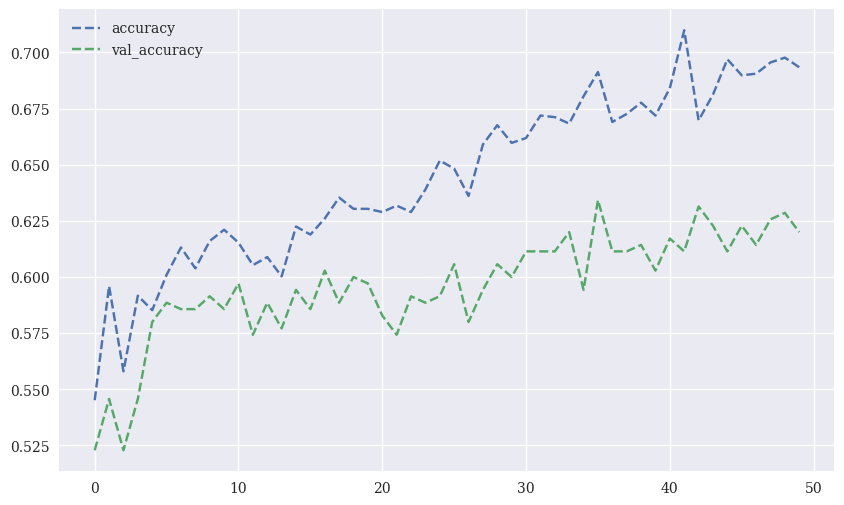

In [47]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [48]:
res.mean()['accuracy'] - res.mean()['val_accuracy']

np.float64(0.04836979031562805)

### Bagging

In [51]:
from sklearn.ensemble import BaggingClassifier
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

In [52]:
max_features = 0.75

In [53]:
set_seeds()
base_estimator = KerasClassifier(model=create_model,
                        verbose=False, epochs=20, hl=1, hu=128,
                        dropout=0.3, regularize=False,
                        input_dim=int(len(cols) * max_features))

In [54]:
model_bag = BaggingClassifier(estimator=base_estimator,
                          n_estimators=15,
                          max_samples=0.75,
                          max_features=max_features,
                          bootstrap=True,
                          bootstrap_features=True,
                          n_jobs=1,
                          random_state=100,
                         )

In [55]:
%time model_bag.fit(train_[cols], train['d'])

CPU times: total: 38.6 s
Wall time: 31.9 s


,estimator,KerasClassifi..._weight=None )
,n_estimators,15
,max_samples,0.75
,max_features,0.75
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,1
,random_state,100
,verbose,0


In [56]:
model_bag.score(train_[cols], train['d'])

0.7056128293241696

In [57]:
model_bag.score(test_[cols], test['d'])

0.6636155606407322

In [58]:
test['p'] = model_bag.predict(test_[cols])

In [59]:
test['p'].value_counts()

p
0    417
1     20
Name: count, dtype: int64

### Optimizers

In [60]:
import time
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']

In [61]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128, dropout=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )
    t0 = time.time()
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 5.9921 | in-sample=0.6243 | out-of-sample=0.6545
rmsprop    | time[s]: 6.3573 | in-sample=0.7457 | out-of-sample=0.6247
adagrad    | time[s]: 6.2779 | in-sample=0.6140 | out-of-sample=0.6018
adadelta   | time[s]: 6.7204 | in-sample=0.4330 | out-of-sample=0.4188
adam       | time[s]: 6.8897 | in-sample=0.7572 | out-of-sample=0.6339
adamax     | time[s]: 8.5313 | in-sample=0.6609 | out-of-sample=0.6545
nadam      | time[s]: 9.5723 | in-sample=0.7457 | out-of-sample=0.6362
CPU times: total: 1min 9s
Wall time: 53.8 s


In [62]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [63]:
test['p'].value_counts()

p
0    249
1    188
Name: count, dtype: int64

In [64]:
accuracy_score(test['p'], test['d'])

0.6361556064073226

## Recurrent Neural Networks

In [65]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

### Financial Price Series

In [66]:
def generate_data():
    data = pd.DataFrame(raw['CLOSE'])
    data.columns = [symbol]
    data = data.resample('30min', label='right').last().ffill()
    return data

data = generate_data()
data = (data - data.mean()) / data.std()
p = data[symbol].values
p = p.reshape((len(p), -1))
lags = 5
g = TimeseriesGenerator(p, p, length=lags, batch_size=5)

In [67]:
def create_rnn_model(hu=100, lags=lags, layer='SimpleRNN', features=1, algorithm='estimation'):
    """Build an RNN/LSTM model using Functional API to avoid input_shape warning.
    hu: hidden units
    lags: sequence length
    layer: 'SimpleRNN' or 'LSTM'
    features: number of features per timestep
    algorithm: 'estimation' (regression) or 'classification'
    """
    keras.backend.clear_session()
    inputs = keras.Input(shape=(lags, features), name="sequence")
    if layer == 'SimpleRNN':
        x = SimpleRNN(hu, activation='relu')(inputs)
    else:
        x = LSTM(hu, activation='relu')(inputs)

    if algorithm == 'estimation':
        outputs = Dense(1, activation='linear')(x)
        loss = 'mse'
        metrics = ['mae']
    else:
        outputs = Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
        metrics = ['accuracy']

    model = keras.Model(inputs=inputs, outputs=outputs, name=f"{layer}_{algorithm}")
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

In [68]:
model = create_rnn_model()

In [69]:
%%time
model.fit(g, epochs=500, steps_per_epoch=10,
          verbose=False)

d:\anaconda3\envs\teaching\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CPU times: total: 12.1 s
Wall time: 6.48 s


<Axes: xlabel='Date'>

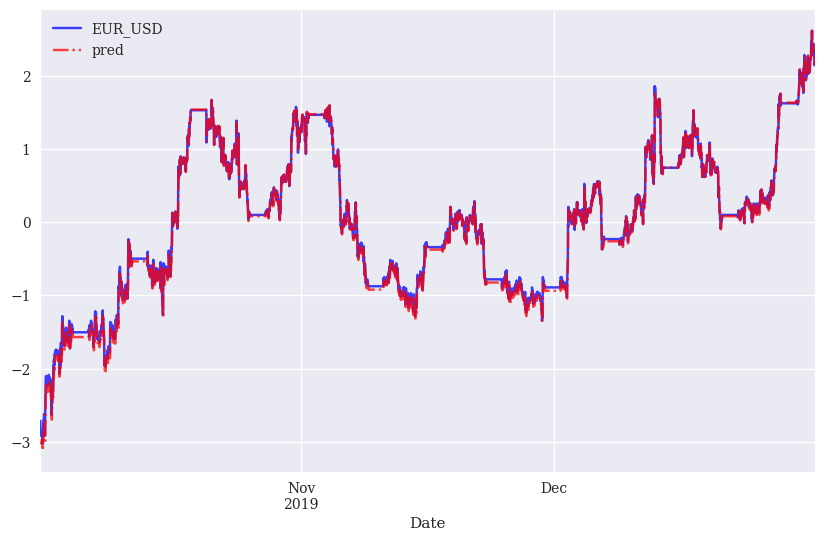

In [70]:
y = model.predict(g, verbose=False)
data['pred'] = np.nan
data.loc[data.index[lags:], 'pred'] = y
data[[symbol, 'pred']].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75)

<Axes: xlabel='Date'>

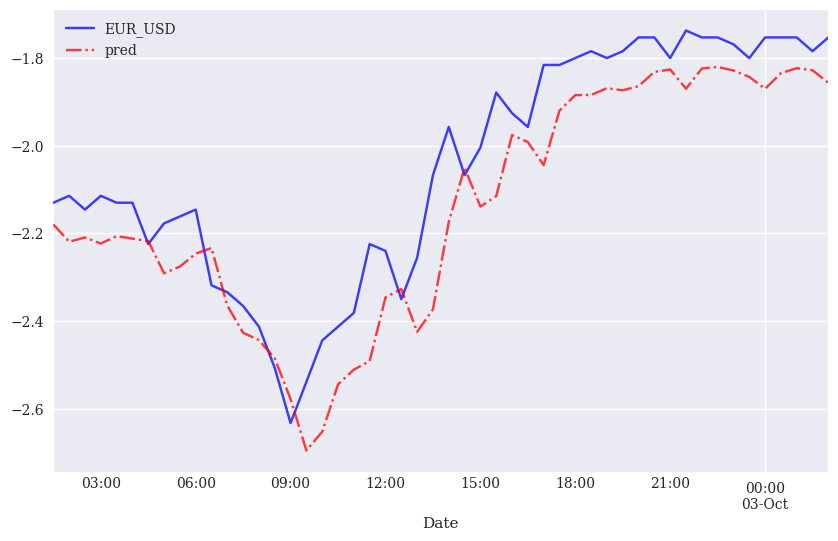

In [71]:
data[[symbol, 'pred']].iloc[50:100].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75)

### Financial Return Series 

In [72]:
data = generate_data()
data['r'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data = (data - data.mean()) / data.std()
r = data['r'].values
r = r.reshape((len(r), -1))
g = TimeseriesGenerator(r, r, length=lags, batch_size=5)
model = create_rnn_model()

In [73]:
%%time
model.fit(g, epochs=500, steps_per_epoch=10,
          verbose=False)

d:\anaconda3\envs\teaching\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CPU times: total: 11.6 s
Wall time: 6.39 s


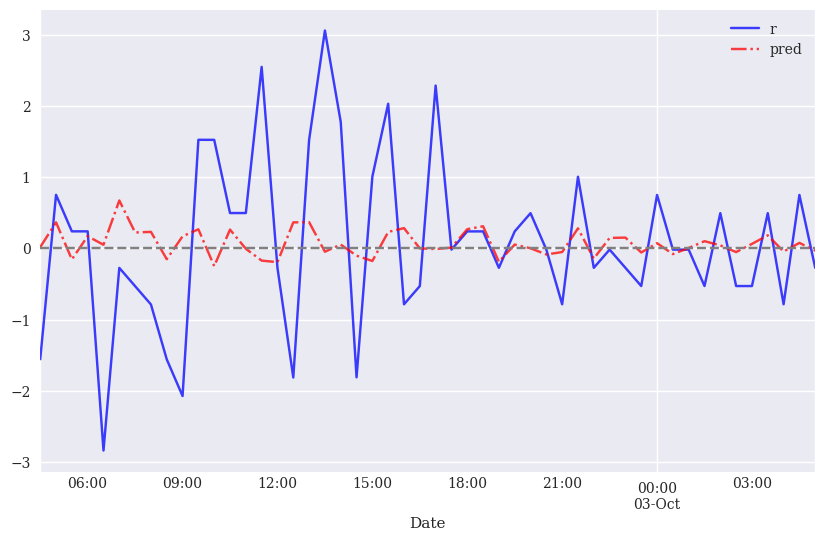

In [74]:
y = model.predict(g, verbose=False)
data['pred'] = np.nan
data.loc[data.index[lags:], 'pred'] = y.flatten()
data.dropna(inplace=True)
data[['r', 'pred']].iloc[50:100].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);
plt.axhline(0, c='grey', ls='--')

In [75]:
from sklearn.metrics import accuracy_score

accuracy_score(np.sign(data['r']), np.sign(data['pred']))

0.6591063733272851

In [76]:
split = int(len(r) * 0.8)
train = r[:split]
test = r[split:]
g = TimeseriesGenerator(train, train, length=lags, batch_size=5)
set_seeds()
model = create_rnn_model(hu=100)

In [77]:
%%time
model.fit(g, epochs=100, steps_per_epoch=10, verbose=False)

d:\anaconda3\envs\teaching\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CPU times: total: 3.12 s
Wall time: 1.96 s


In [78]:
g_ = TimeseriesGenerator(test, test, length=lags, batch_size=5)
y = model.predict(g_)
accuracy_score(np.sign(test[lags:]), np.sign(y))

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.6605922551252847

### Financial Features

In [79]:
data = generate_data()
data['r'] = np.log(data / data.shift(1))
window = 20
data['mom'] = data['r'].rolling(window).mean()
data['vol'] = data['r'].rolling(window).std()
data.dropna(inplace=True)

#### Estimation

In [80]:
split = int(len(data) * 0.8)
train = data.iloc[:split].copy()
mu, std = train.mean(), train.std()
train = (train - mu) / std
test = data.iloc[split:].copy()
test = (test - mu) / std
g = TimeseriesGenerator(train.values, train['r'].values,
                        length=lags, batch_size=5)
set_seeds()
model = create_rnn_model(hu=100, features=len(data.columns),
                         layer='SimpleRNN')

In [81]:
%%time
model.fit(g, epochs=100, steps_per_epoch=10,
                verbose=False)

d:\anaconda3\envs\teaching\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CPU times: total: 3.41 s
Wall time: 1.96 s


In [82]:
g_ = TimeseriesGenerator(test.values, test['r'].values,
                         length=lags, batch_size=5)
y = model.predict(g_).flatten()
accuracy_score(np.sign(test['r'].iloc[lags:]), np.sign(y))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.35583524027459956

#### Classification

In [83]:
set_seeds()
model = create_rnn_model(hu=50,
            features=len(data.columns),
            layer='LSTM',
            algorithm='classification')
train_y = np.where(train['r'] > 0, 1, 0)
np.bincount(train_y)

array([2374, 1142])

In [84]:
def cw(a):
    c0, c1 = np.bincount(a)
    w0 = (1 / c0) * (len(a)) / 2
    w1 = (1 / c1) * (len(a)) / 2
    return {0: w0, 1: w1}

In [85]:
g = TimeseriesGenerator(train.values, train_y,
                        length=lags, batch_size=5)

In [86]:
%%time
model.fit(g, epochs=5, steps_per_epoch=10,
          verbose=False, class_weight=cw(train_y))

CPU times: total: 1.16 s
Wall time: 1.13 s


In [87]:
test_y = np.where(test['r'] > 0, 1, 0)
g_ = TimeseriesGenerator(test.values, test_y,
                         length=lags, batch_size=5)
y = np.where(model.predict(g_, batch_size=None) > 0.5,
             1, 0).flatten()
np.bincount(y)
accuracy_score(test_y[lags:], y)

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.6167048054919908